In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time
import random
from sklearn import tree

In [6]:
num_experiments = 100
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [7]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [9]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [11]:
all_data = [read_data(file_name) for i,file_name in enumerate(data_files) if i not in unrun_files]

In [19]:
def plot(num,func):
    all_times = sorted(set([i.time for i in all_data[num]]))
        
    x = []
    y = []
    
    for i in all_times:
        x.append(i)
        y.append(func(all_data[num],i))
        
    plt.plot(x,y)
    

In [26]:
Y = get_rewards(data_files,lambda s: len(s))

In [30]:
run_to_completion = Y>5000
run_to_completion

array([[False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [

In [35]:
X_full, Y_full = X[run_to_completion.flatten(),:], Y[run_to_completion.flatten()]

In [54]:
X_full[0,:] = np.lcm(X_full[0,:].astype(int),25)

In [39]:
data_full = [data for i,data in enumerate(all_data) if run_to_completion[i,0] == True]

In [46]:
num_blob_data = [[num_blobs_cells(data,j) for j in range(0,50000,1000)] for data in data_full]

In [47]:
num_blob_data = np.array(num_blob_data)

In [48]:
num_blob_data.shape

(75, 50)

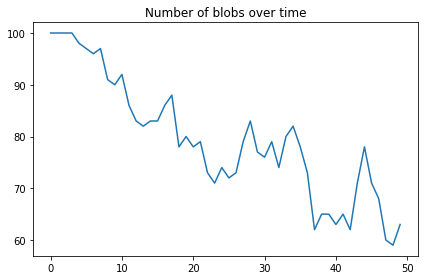

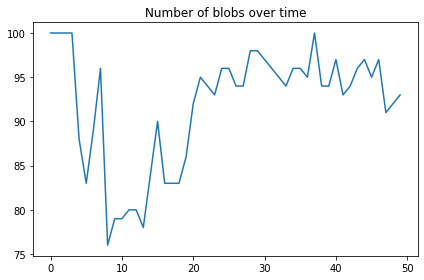

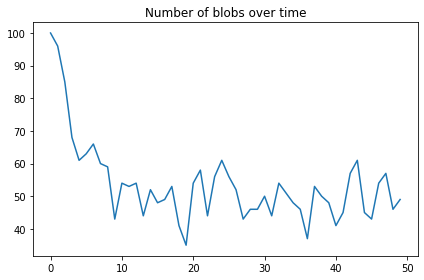

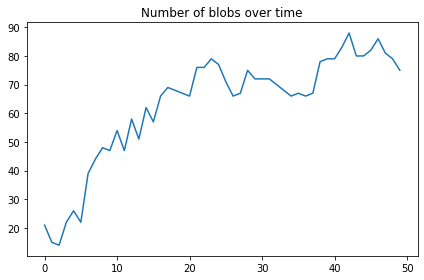

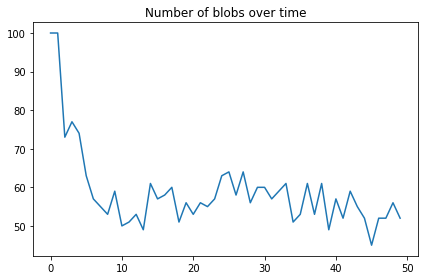

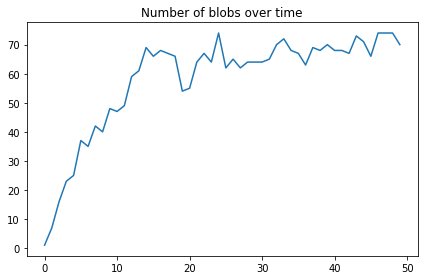

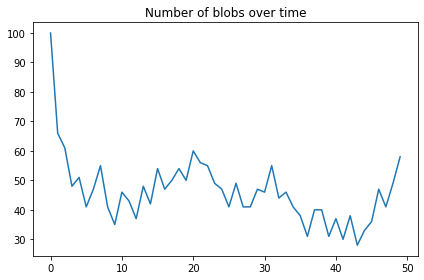

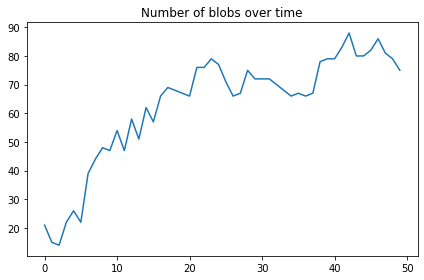

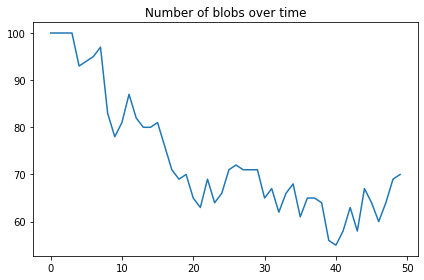

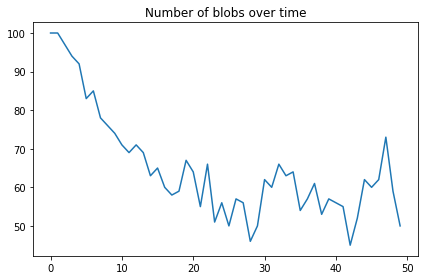

<Figure size 432x288 with 0 Axes>

In [51]:
for i in range(10):
    plt.title("Number of blobs over time")
    index = random.randint(0,len(num_blob_data)-1)
    plt.plot(list(range(len(num_blob_data[index]))),num_blob_data[index])
    plt.tight_layout()
    plt.figure()

In [147]:
emukit_model = get_emukit_model(X_full,(num_blob_data[:,-1]).reshape(len(num_blob_data),1),
                                lengthscale=50,variance=100,noise_var=10)

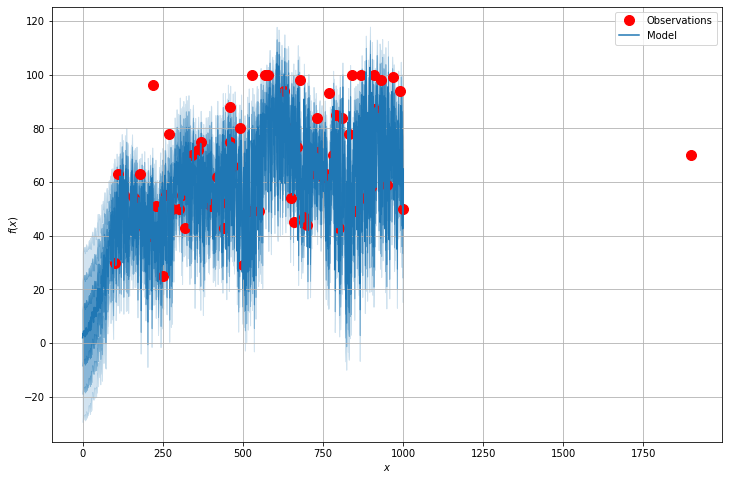

In [148]:
plot_gaussian_process(np.linspace(0,1000,1000),0,parameter_space,emukit_model)

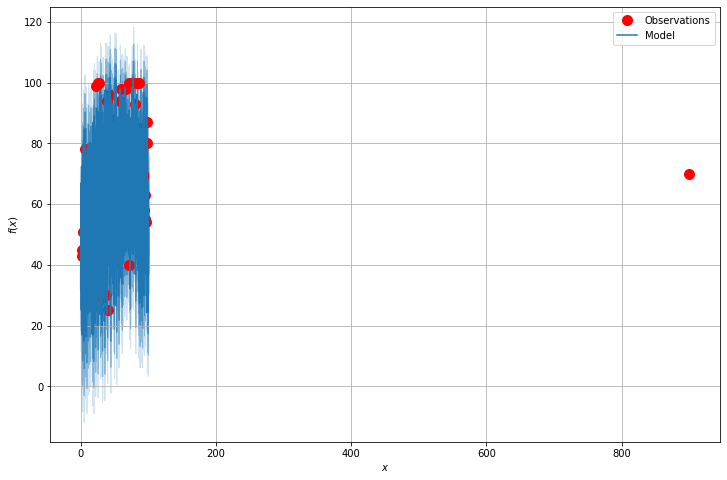

In [149]:
plot_gaussian_process(np.linspace(0,100,1000),3,parameter_space,emukit_model)

In [134]:
emukit_model = get_emukit_model(X_full,(num_blob_data[:,0]-num_blob_data[:,-1]).reshape(len(num_blob_data),1),
                                lengthscale=100,variance=10,noise_var=10)

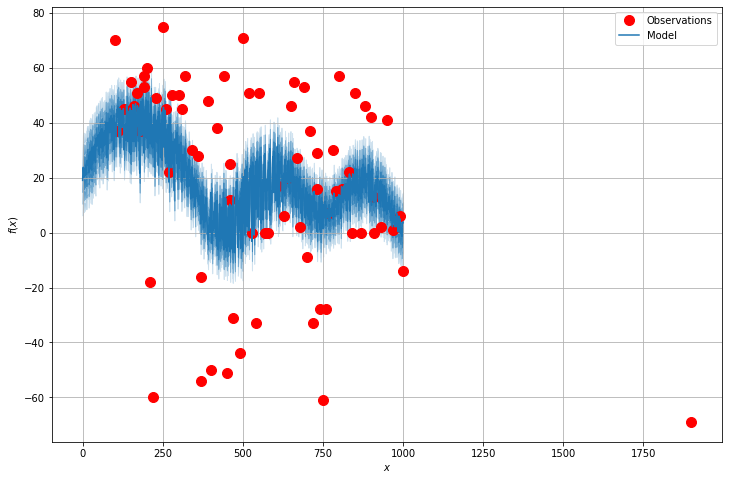

In [135]:
plot_gaussian_process(np.linspace(0,1000,1000),0,parameter_space,emukit_model)

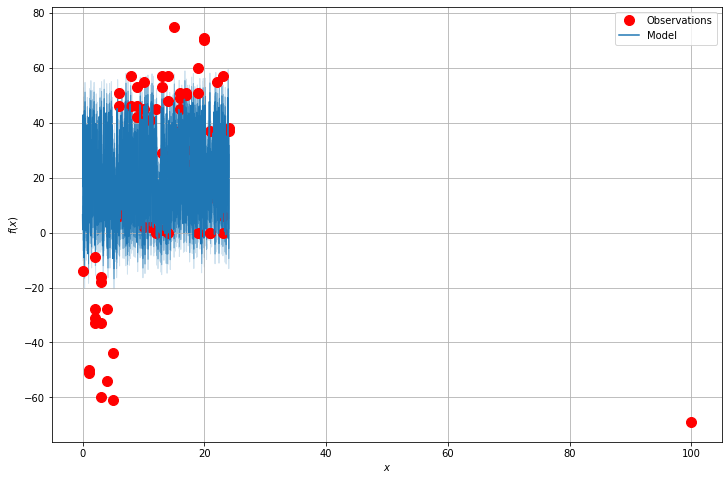

In [136]:
plot_gaussian_process(np.linspace(0,24,1000),1,parameter_space,emukit_model)

In [129]:
get_sobol_indices(emukit_model,parameter_space)

({'season_duration': array([0.78165134]),
  'gamma': array([0.0145068]),
  'mut_rate': array([-0.0086806]),
  'T': array([0.11218877]),
  'target_area': array([0.00019767]),
  'gradnoise': array([-0.00868081])},
 {'season_duration': array([0.86649296]),
  'gamma': array([0.05471877]),
  'mut_rate': array([0.02345254]),
  'T': array([0.1697948]),
  'target_area': array([0.05938389]),
  'gradnoise': array([0.02345353])})

In [157]:
clf = tree.DecisionTreeClassifier()
temp_Y = num_blob_data[:,-1]-num_blob_data[:,0]

clf.fit(X_full,np.sign(temp_Y).reshape(len(num_blob_data),1))

DecisionTreeClassifier()

In [158]:
temp_Y

array([ 69, -45,  -7, -51,  -2, -57,  33, -53, -16, -29, -12, -50,   0,
       -48, -27, -46, -51, -57, -37,  33, -37,  14,  51, -53, -70, -30,
        31, -57, -13,  60, -41,  -2,   0,  -1, -49, -51, -60, -20,   0,
       -28,  -6, -46, -25,  54, -71, -57, -22,   0,  28, -16,  -6, -22,
        18, -55, -50, -30, -51, -15,  44, -38,  16, -75,  28,   9,  50,
       -17, -37, -45, -55,   0, -42, -46,   0, -45,  61])

In [161]:
np.set_printoptions(suppress=True)
X_full[[i for i in range(len(temp_Y)) if temp_Y[i] > 0]]

array([[1900.    ,  100.    ,    0.    ,  900.    ,  850.    ,    0.    ],
       [ 540.    ,    2.    ,    0.3525,   92.575 ,   88.    ,    0.6533],
       [ 720.    ,    3.    ,    0.0325,   17.335 ,   66.    ,    0.3647],
       [1000.    ,    0.    ,    0.0525,   54.955 ,   79.    ,    0.6681],
       [ 450.    ,    1.    ,    0.3975,   43.075 ,   44.    ,    0.3721],
       [ 470.    ,    2.    ,    0.2175,   72.775 ,   61.    ,    0.4535],
       [ 220.    ,    3.    ,    0.0125,   44.065 ,   94.    ,    0.6607],
       [ 370.    ,    4.    ,    0.0925,   50.005 ,   54.    ,    0.2611],
       [ 760.    ,    4.    ,    0.2625,   49.015 ,   96.    ,    0.7273],
       [ 210.    ,    3.    ,    0.3475,   70.795 ,   91.    ,    0.8309],
       [ 490.    ,    5.    ,    0.0625,   98.515 ,   70.    ,    0.7717],
       [ 370.    ,    3.    ,    0.2225,   14.365 ,   83.    ,    0.8605],
       [ 740.    ,    2.    ,    0.2825,   95.545 ,   76.    ,    0.5127],
       [ 700.    ,    2. 

In [165]:
temp_Y[[i for i in range(len(temp_Y)) if temp_Y[i] > 0]].reshape(16,1)

array([[69],
       [33],
       [33],
       [14],
       [51],
       [31],
       [60],
       [54],
       [28],
       [18],
       [44],
       [16],
       [28],
       [ 9],
       [50],
       [61]])

[Text(251.10000000000002, 587.0880000000001, 'X[1] <= 5.5\ngini = 0.449\nsamples = 75\nvalue = [53, 6, 16]'),
 Text(167.4, 456.624, 'gini = 0.0\nsamples = 15\nvalue = [0, 0, 15]'),
 Text(334.8, 456.624, 'X[2] <= 0.033\ngini = 0.209\nsamples = 60\nvalue = [53, 6, 1]'),
 Text(167.4, 326.1600000000001, 'X[5] <= 0.153\ngini = 0.278\nsamples = 6\nvalue = [0, 5, 1]'),
 Text(83.7, 195.69600000000003, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(251.10000000000002, 195.69600000000003, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text(502.20000000000005, 326.1600000000001, 'X[2] <= 0.07\ngini = 0.036\nsamples = 54\nvalue = [53, 1, 0]'),
 Text(418.5, 195.69600000000003, 'X[2] <= 0.063\ngini = 0.375\nsamples = 4\nvalue = [3, 1, 0]'),
 Text(334.8, 65.23200000000008, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(502.20000000000005, 65.23200000000008, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(585.9, 195.69600000000003, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]')]

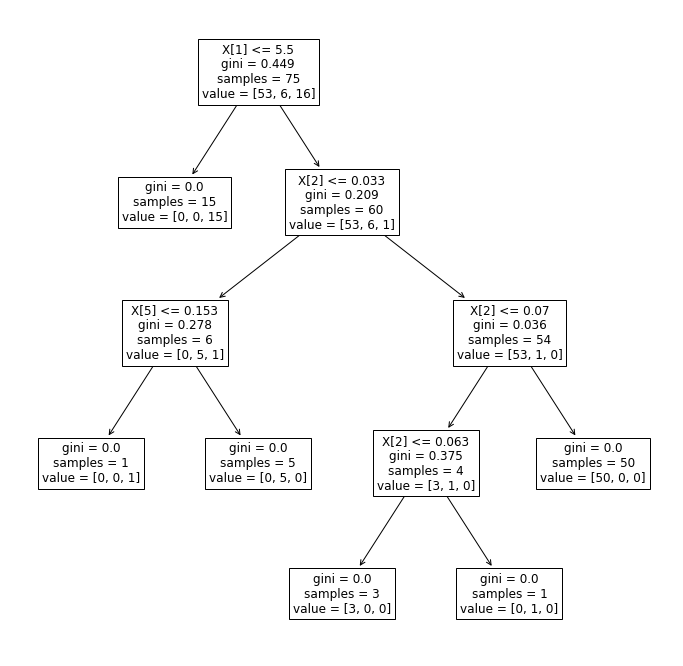

In [159]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)